# Predicting Loan Default Risk 

https://www.kaggle.com/c/home-credit-default-risk

Predict the probabilty an applicant will default on a loan.

The main source is an application (identified by a unique SK_ID_CURR). The main source is imported as train and test. There are 6 other data sources at differing grains. Each source is imported and then aligned to the grain of one application. In order to align, a dataframe named df_all_ids is first created with all the SK_ID_CURR of that source. When preprocessing and data engineering is complete for each source, the dataframe df_all_ids is joined to the primary dataframes of train and test. The process then begins for the next source.  Once all the sources are imported, the primary dataframes are copied and renamed train_X and test_X. The columns are aligned and features are scaled. LightGBM with crossfold validation is the algorithm used. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import gc
from lightgbm import LGBMClassifier
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import os
import warnings
warnings.filterwarnings('ignore')

# Automatically give the time taken to execute each cell
# Install with pip install ipython-autotime 
%load_ext autotime

# Plotting Graphs Configuration
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 14, 7
plt.style.use('seaborn-whitegrid')

C:\Users\bth\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Application Data

In [2]:
train = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')
traintarget = train[['SK_ID_CURR', 'TARGET']].copy()

train.set_index("SK_ID_CURR", inplace = True)
test.set_index("SK_ID_CURR", inplace = True)

time: 4.89 s


In [3]:
def app_preprocessing(df):
    """drop_these_columns = [ 'WALLSMATERIAL_MODE','ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 
          'REGION_RATING_CLIENT', 'HOUSETYPE_MODE', 'CNT_CHILDREN', 'OBS_60_CNT_SOCIAL_CIRCLE', 
          'DEF_60_CNT_SOCIAL_CIRCLE', LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 
          'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_DAY',
          'FLAG_CONT_MOBILE', 'FLAG_MOBIL', 'FLAG_EMAIL', 'FLAG_PHONE', 'NAME_TYPE_SUITE',
          'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'REG_REGION_NOT_WORK_REGION', 'EMERGENCYSTATE_MODE',
          'REG_REGION_NOT_LIVE_REGION', 'WEEKDAY_APPR_PROCESS_START',
          'FLAG_EMP_PHONE', 'REG_CITY_NOT_WORK_CITY']  
    df.drop(drop_these_columns, axis=1, inplace=True)
    """
    
    df.fillna({ 'EMERGENCYSTATE_MODE': 'No',
                    'OCCUPATION_TYPE': 'unknown',
                    'NAME_TYPE_SUITE': 'unknown',
                    'CNT_FAM_MEMBERS': 1, 
                    'EXT_SOURCE_1': df['EXT_SOURCE_1'].median(),
                    'EXT_SOURCE_2': df['EXT_SOURCE_2'].median(),
                    'EXT_SOURCE_3': df['EXT_SOURCE_3'].median(),
                    'OWN_CAR_AGE': df['OWN_CAR_AGE'].median(), 
                    'AMT_GOODS_PRICE': df['AMT_GOODS_PRICE'].median(), 
                    'AMT_ANNUITY': df['AMT_ANNUITY'].median(), 
                    'TOTALAREA_MODE': df['TOTALAREA_MODE'].median()   
                     }, inplace=True)
    df['NAME_EDUCATION_TYPE'].replace({'Higher education': 'Higher',
                                     'Academic degree': 'Higher',
                                     'Incomplete higher':'Secondary',
                                     'Lower secondary': 'Secondary',
                                     'Secondary / secondary special':'Secondary'}, inplace=True)
    df['CODE_GENDER'].replace('XNA', 'F', inplace=True) 
    
    df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)
  
    return df

train = app_preprocessing(train)
test = app_preprocessing(test)

time: 270 ms


In [4]:
le = LabelEncoder()
for col in train: 
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2:          
            le.fit(train[col])  
            train[col] = le.transform(train[col]) 
            test[col] = le.transform(test[col]) 

def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

train, train_cat = one_hot_encoder(train)
test, test_cat = one_hot_encoder(test)

time: 2.9 s


In [5]:
def fill_na_with(df, strategy_ = 'median'):
    imputer = Imputer(strategy = strategy_, axis = 0)
    return pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)

train = fill_na_with(train)
test = fill_na_with(test)

time: 18.3 s


In [6]:
def app_feature_engineering(df):    
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] 
    df['CREDIT_TO_INCOME_RATIO'] =  df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] 
    df['CREDIT_TO_ANNUITY_RATIO'] =  df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] =  df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] 
    df['INCOME_PERPERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']  
    df['CREDIT_PERPERSON'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']   
    df['INCOME_MINUS_CREDIT_PERPERSON'] = (df['AMT_INCOME_TOTAL'] - df['AMT_CREDIT']) / df['CNT_FAM_MEMBERS']  
    df['CARAGE_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE']  / df['DAYS_BIRTH'] 
    df['PHONETO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE']  / df['DAYS_BIRTH'] 
    df['OBS_30_DEFAULT_RATIO'] = df ['DEF_30_CNT_SOCIAL_CIRCLE'] / df['OBS_30_CNT_SOCIAL_CIRCLE']
    
app_feature_engineering(train)
app_feature_engineering (test)

train = fill_na_with(train)
test = fill_na_with(test)

time: 11 s


# Additional Data Files

### Additional Source: Bureau and Bureau Balance


In [7]:
bureau = pd.read_csv('data/bureau.csv')
bureau = bureau.add_prefix('bureau_') #add prefix showing source
bureau = bureau.rename(columns = {'bureau_SK_ID_CURR': 'SK_ID_CURR', 'bureau_SK_ID_BUREAU': 'SK_ID_BUREAU',}) #remove prefix from id
bureau = bureau.fillna(0) 

bb = pd.read_csv('data/bureau_balance.csv')
bb = bb.add_prefix('bb_') #add prefix showing source
bb = bb.rename(columns = { 'bb_SK_ID_BUREAU': 'SK_ID_BUREAU',}) #remove prefix from id
bb = bb.fillna(0)

df_all_ids = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()}) #used to align grain

time: 13.5 s


In [8]:
# align to grain of SK_ID_BUREAU
bb, bb_cat = one_hot_encoder(bb)

grp = bb.groupby(['SK_ID_BUREAU']).agg({
        'bb_MONTHS_BALANCE': ['size'],
        'bb_STATUS_X': ['sum'],
        'bb_STATUS_C': ['sum'],
        'bb_STATUS_1': ['sum']
})
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
bureau = bureau.join(grp, on = ['SK_ID_BUREAU'], how = 'left') 

# formulas on grain of SK_ID_BUREAU
bureau['bb_STATUS_X_PERCENT'] = bureau['bb_STATUS_X_sum'] / bureau['bb_MONTHS_BALANCE_size']
bureau['bb_STATUS_C_PERCENT'] = bureau['bb_STATUS_C_sum'] / bureau['bb_MONTHS_BALANCE_size']
bureau['bb_STATUS_1_PERCENT'] = bureau['bb_STATUS_1_sum'] / bureau['bb_MONTHS_BALANCE_size']

time: 7.08 s


In [9]:
groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

# created at level of bureau
bureau['bureau_CREDIT_ACTIVE_FLAG'] = (bureau['bureau_CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_CREDIT_ENDDATE_FLAG'] = (bureau['bureau_DAYS_CREDIT_ENDDATE'] > 0).astype(int)

grp = groupby_SK_ID_CURR['bureau_DAYS_CREDIT'].agg('count').reset_index()
grp.rename(index=str, columns={'bureau_DAYS_CREDIT': 'bureau_NUMBER_PAST_LOANS'},inplace=True)
df_all_ids = df_all_ids.merge(grp, on=['SK_ID_CURR'], how='left')

grp = groupby_SK_ID_CURR['bureau_CREDIT_TYPE'].agg('nunique').reset_index()
grp.rename(index=str, columns={'bureau_CREDIT_TYPE': 'bureau_NUMBER_LOAN_TYPES'},inplace=True)
df_all_ids = df_all_ids.merge(grp, on=['SK_ID_CURR'], how='left')
df_all_ids = fill_na_with(df_all_ids)

df_all_ids['bureau_PASTLOANS_PER_TYPE_RATIO'] = df_all_ids['bureau_NUMBER_PAST_LOANS'] / df_all_ids['bureau_NUMBER_LOAN_TYPES']

bureau, cat_cols = one_hot_encoder(bureau)

# align to grain of SK_ID_CURR
grp = bureau.groupby(['SK_ID_CURR']).agg({
        'bureau_CREDIT_ACTIVE_FLAG': ['sum', 'mean'],  
        'bureau_CREDIT_ENDDATE_FLAG': ['sum', 'mean'], 
        'bureau_DAYS_CREDIT_ENDDATE': ['mean', 'max','min', 'var'],
        'bureau_DAYS_CREDIT_UPDATE': ['mean', 'max','min','var'], 
        'bureau_AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max','min','var'], 
        'bureau_AMT_CREDIT_SUM_OVERDUE': ['sum', 'max','min','var', 'mean'], 
        'bureau_AMT_CREDIT_MAX_OVERDUE': ['mean', 'max','min','var'], 
        'bureau_AMT_CREDIT_SUM': ['sum', 'max','min','var', 'mean'], 
        'bureau_AMT_CREDIT_SUM_LIMIT': ['sum', 'max','min','var'], 
        'bureau_AMT_ANNUITY': ['sum', 'mean', 'max','min','var'],  
        'bureau_DAYS_CREDIT': ['mean','max','min','var'], 
        'bb_STATUS_X_PERCENT': ['mean', 'max','min','var'],
        'bb_STATUS_C_PERCENT': ['mean', 'max','min','var'], 
        'bb_STATUS_1_PERCENT': ['mean', 'max','min','var'], 
        'bb_MONTHS_BALANCE_size': ['max', 'var','sum', 'mean'],
        'bureau_CREDIT_TYPE_Credit card': ['sum'],
        'bureau_CREDIT_TYPE_Microloan': ['sum']
})
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, on = ['SK_ID_CURR'], how = 'left')

"""
# aggregations separately for active
num_aggregations = {
        'bureau_DAYS_CREDIT': ['max', 'var', 'mean'], 
        'bureau_DAYS_CREDIT_ENDDATE': ['min', 'mean'],
        'bureau_DAYS_CREDIT_UPDATE': ['mean', 'max','min'], 
        'bureau_AMT_CREDIT_SUM_LIMIT': ['mean', 'max','min'], 
        'bb_MONTHS_BALANCE_size': ['sum']
    }

active = bureau[bureau['bureau_CREDIT_ACTIVE_FLAG'] == 1]
grp = active.groupby('SK_ID_CURR').agg(num_aggregations)
grp.columns = pd.Index([e[0] + "_" + e[1] + "_ACTIVE" for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, how='left', on='SK_ID_CURR')
df_all_ids = fill_na_with(df_all_ids)    
"""
df_all_ids['bureau_CREDIT_MINUS_OVERDUE'] = df_all_ids['bureau_AMT_CREDIT_SUM_mean'] - df_all_ids['bureau_AMT_CREDIT_SUM_OVERDUE_mean'] 
df_all_ids['bureau_MONTHSBALANCE_DIVIDEDBY_DAYSCREDIT'] = df_all_ids['bb_MONTHS_BALANCE_size_mean'] / df_all_ids['bureau_DAYS_CREDIT_mean'] 

df_all_ids = fill_na_with(df_all_ids)

time: 10.1 s


In [10]:
df_all_ids.set_index('SK_ID_CURR', inplace = True)

train = train.merge(df_all_ids, how='left', left_index = True, right_index = True)
test = test.merge(df_all_ids, how='left', left_index = True, right_index = True)

train = fill_na_with(train)
test = fill_na_with(test)

gc.enable()
del bb, bureau, df_all_ids, grp
gc.collect()

481

time: 18.6 s


### Additional Source: POS Cash Balance

In [11]:
pos = pd.read_csv('data/POS_Cash_balance.csv')
pos = pos.add_prefix('cash_') #add prefix showing source
pos = pos.rename(columns = {'cash_SK_ID_CURR': 'SK_ID_CURR'}) #remove prefix from id
pos = pos.fillna(0)

df_all_ids = pd.DataFrame({'SK_ID_CURR':pos['SK_ID_CURR'].unique()}) #use to align grain

time: 8.33 s


In [12]:
# Retrieve most recent row per cash loan (group of SK_ID_CURR and cash_SK_ID_PREV)
grp = pos.groupby(['SK_ID_CURR', 'cash_SK_ID_PREV'], as_index=False).first()
grp['cash_FUTURE_RATIO'] = grp['cash_CNT_INSTALMENT_FUTURE'] / grp['cash_CNT_INSTALMENT']
grp['cash_CONTRACT_STATUS_ACTIVE'] = 0
grp['cash_CONTRACT_STATUS_ACTIVE'] = grp['cash_CONTRACT_STATUS_ACTIVE'].mask(grp['cash_NAME_CONTRACT_STATUS'] == 'Active', 1)

# align from grain of SK_ID_PREV to grain of SK_ID_CURR
grp1 = grp.groupby(['SK_ID_CURR']).agg({
            'cash_CONTRACT_STATUS_ACTIVE': ['sum'],
            'cash_FUTURE_RATIO': ['min'],
            'cash_CNT_INSTALMENT_FUTURE': ['mean', 'max','min'] 
        })
grp1.columns = pd.Index([e[0] + '_' + e[1] for e in grp1.columns.tolist()])
df_all_ids = df_all_ids.join(grp1, on = ['SK_ID_CURR'], how = 'left')

# Calculates days late
pos['cash_SK_DPD_late'] = 0
pos['cash_SK_DPD_late'] = pos['cash_SK_DPD_late'].mask(pos['cash_SK_DPD'] >= 1, 1)

# Fields calculated at grain of month installment
pos, cat_cols = one_hot_encoder(pos)

# align to grain of SK_ID_CURR
grp = pos.groupby(['SK_ID_CURR']).agg({
        'cash_MONTHS_BALANCE': ['min', 'mean'], 
        'cash_CNT_INSTALMENT': ['max', 'mean'],
        'cash_SK_DPD_late': ['mean', 'max'] 
        })
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, on = ['SK_ID_CURR'], how = 'left')
df_all_ids = fill_na_with(df_all_ids)

time: 11 s


In [13]:
df_all_ids.set_index('SK_ID_CURR', inplace = True)

train = train.merge(df_all_ids, how='left', left_index = True, right_index = True)
test = test.merge(df_all_ids, how='left', left_index = True, right_index = True)

train = fill_na_with(train)
test = fill_na_with(test) 

gc.enable()
del pos, df_all_ids, grp
gc.collect()

287

time: 14.4 s


### Additional Source: CC Balance

In [14]:
cc = pd.read_csv('data/credit_card_balance.csv')
cc = cc.add_prefix('cc_') #add prefix showing source
cc = cc.rename(columns = {'cc_SK_ID_CURR': 'SK_ID_CURR'}) #remove prefix from id
cc = cc.fillna(0)

df_all_ids = pd.DataFrame({'SK_ID_CURR':cc['SK_ID_CURR'].unique()}) #use to align grain

time: 11.5 s


In [15]:
cc, cat_cols = one_hot_encoder(cc) 

# align to grain of SK_ID_CURR
grp = cc.groupby(['SK_ID_CURR']).agg({
                    'cc_MONTHS_BALANCE': ['min', 'max', 'mean'], 
                    'cc_AMT_BALANCE': ['mean', 'max','min'], 
                    'cc_AMT_DRAWINGS_CURRENT': ['mean', 'max','min'], 
                    'cc_SK_DPD_DEF': ['mean', 'max','min'], 
                    'cc_CNT_INSTALMENT_MATURE_CUM': ['mean', 'max','min'], 
                    'cc_AMT_DRAWINGS_ATM_CURRENT': ['mean', 'max','min'], 
                    'cc_AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max','min'],
                    'cc_AMT_DRAWINGS_ATM_CURRENT': ['mean', 'max','min'],
                    'cc_AMT_DRAWINGS_OTHER_CURRENT': ['mean', 'max','min'],
                    'cc_AMT_INST_MIN_REGULARITY': ['mean', 'max','min'],
                    'cc_AMT_RECEIVABLE_PRINCIPAL': ['mean', 'max','min'],
                    'cc_AMT_TOTAL_RECEIVABLE': ['mean', 'max','min']
            })
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, on = ['SK_ID_CURR'], how = 'left')
df_all_ids = fill_na_with(df_all_ids)

#fields created at grain of SK_ID_CURR
df_all_ids['cc_ATM_TO_TOTALDRAW_RATIO'] = df_all_ids['cc_AMT_DRAWINGS_ATM_CURRENT_mean'] / df_all_ids[
    'cc_AMT_DRAWINGS_CURRENT_mean']

time: 3.38 s


In [16]:
df_all_ids.set_index('SK_ID_CURR', inplace = True)

train = train.merge(df_all_ids, how='left', left_index = True, right_index = True)
test = test.merge(df_all_ids, how='left', left_index = True, right_index = True)

train = fill_na_with(train)
test = fill_na_with(test)

gc.enable()
del cc, df_all_ids, grp
gc.collect()

242

time: 16.1 s


### Additional Source: Previous Application

In [17]:
prevapp = pd.read_csv('data/previous_application.csv')
prevapp = prevapp.add_prefix('prevapp_') #add prefix showing source
prevapp = prevapp.rename(columns = {'prevapp_SK_ID_CURR': 'SK_ID_CURR'}) #remove prefix from id
prevapp = prevapp.fillna(0)

df_all_ids = pd.DataFrame({'SK_ID_CURR':prevapp['SK_ID_CURR'].unique()}) #use to align grain

time: 9.27 s


In [18]:
# processing on grain of previous appp
prevapp['prevapp_DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prevapp['prevapp_DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prevapp['prevapp_DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prevapp['prevapp_DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prevapp['prevapp_DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
prevapp['prevapp_ASKED_MINUS_CREDITGIVEN'] = prevapp['prevapp_AMT_APPLICATION'] - prevapp['prevapp_AMT_CREDIT']
prevapp['prevapp_CREDIT_MINUS_GOODSPRICE'] = prevapp['prevapp_AMT_CREDIT'] - prevapp['prevapp_AMT_GOODS_PRICE']

prevapp, cat_cols = one_hot_encoder(prevapp)

# align to grain of SK_ID_CURR
grp = prevapp.groupby(['SK_ID_CURR']).agg({
                    'prevapp_AMT_ANNUITY': ['mean', 'max','min','var'], 
                    'prevapp_AMT_APPLICATION': ['mean', 'max','min', 'var'],    
                    'prevapp_AMT_DOWN_PAYMENT': ['max', 'mean', 'min'],
                    'prevapp_AMT_CREDIT': ['min', 'mean', 'max'], 
                    'prevapp_ASKED_MINUS_CREDITGIVEN': ['max', 'mean', 'min'], 
                    'prevapp_CREDIT_MINUS_GOODSPRICE': ['mean','max', 'min'], 
                    'prevapp_RATE_DOWN_PAYMENT': ['max', 'min'], 
                    'prevapp_DAYS_DECISION': ['max', 'mean'], 
                    'prevapp_CNT_PAYMENT': ['mean', 'max', 'min'], 
                    'prevapp_DAYS_LAST_DUE': ['max', 'mean', 'var'], 
                    'prevapp_NAME_CONTRACT_TYPE_Consumer loans': ['sum'],
                    'prevapp_NAME_CONTRACT_STATUS_Canceled': ['sum'],
                    'prevapp_CODE_REJECT_REASON_HC': ['sum'],         
                    'prevapp_NAME_PRODUCT_TYPE_x-sell': ['sum','mean'], 
                    'prevapp_NAME_PRODUCT_TYPE_walk-in': ['sum','mean'],       
                    'prevapp_NAME_YIELD_GROUP_middle': ['sum', 'mean'], 
                    'prevapp_NAME_YIELD_GROUP_high': ['sum', 'mean'],
                    'prevapp_NAME_YIELD_GROUP_low_action': ['sum', 'mean'],
                    'prevapp_DAYS_FIRST_DRAWING':['mean','max', 'min'],
                    'prevapp_DAYS_FIRST_DUE': ['mean','max', 'min'],
                    'prevapp_DAYS_LAST_DUE_1ST_VERSION': ['mean','max', 'min'],
                    'prevapp_DAYS_TERMINATION': ['mean','max', 'min']
                  })
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, on = ['SK_ID_CURR'], how = 'left')
df_all_ids = fill_na_with(df_all_ids)

num_aggregations = {'prevapp_AMT_CREDIT': ['min'],
                    'prevapp_CNT_PAYMENT': ['sum'],
                  }
approved = prevapp[prevapp['prevapp_NAME_CONTRACT_STATUS_Approved'] == 1]
grp = approved.groupby('SK_ID_CURR').agg(num_aggregations)
grp.columns = pd.Index([e[0] + "_" + e[1] + "_APPROVED" for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, how='left', on='SK_ID_CURR')
df_all_ids = fill_na_with(df_all_ids)

time: 13.2 s


In [19]:
df_all_ids.set_index('SK_ID_CURR', inplace = True)

train = train.merge(df_all_ids, how='left', left_index = True, right_index = True)
test = test.merge(df_all_ids, how='left', left_index = True, right_index = True)
train = fill_na_with(train)
test = fill_na_with(test)

gc.enable()
del prevapp, df_all_ids, grp
gc.collect()

377

time: 20.3 s


### Additional Source: Installment Payments

In [20]:
installpay = pd.read_csv('data/installments_payments.csv')
installpay = installpay.add_prefix('installpay_') #add prefix showing source
installpay = installpay.rename(columns = {'installpay_SK_ID_CURR': 'SK_ID_CURR'}) #remove prefix from id
installpay = installpay.fillna(0)

df_all_ids = pd.DataFrame({'SK_ID_CURR':installpay['SK_ID_CURR'].unique()}) #use to align grain

time: 15.1 s


In [21]:
#create new columns on grain of installment payment
installpay['installpay_BALANCE_DUE'] = installpay['installpay_AMT_PAYMENT']- installpay['installpay_AMT_INSTALMENT']
installpay['installpay_DAYS_DELTA'] = installpay['installpay_DAYS_INSTALMENT']- installpay['installpay_DAYS_ENTRY_PAYMENT']
installpay['installpay_DAYS_LATE_FLAG'] = (installpay['installpay_DAYS_DELTA'] < 0).astype(int)
installpay['installpay_DAYS_LATE'] = installpay['installpay_DAYS_DELTA']
installpay['installpay_DAYS_LATE'] = installpay['installpay_DAYS_LATE'].mask(installpay['installpay_DAYS_DELTA'] > 0, 0)

installpay['installpay_PAID_OVER_AMOUNT'] = installpay['installpay_AMT_PAYMENT'] - installpay['installpay_AMT_INSTALMENT']
installpay['installpay_PAID_OVER_FLAG'] = (installpay['installpay_PAID_OVER_AMOUNT'] > 0).astype(int)

installpay, cat_cols = one_hot_encoder(installpay)

# align to grain of SK_ID_CURR
grp = installpay.groupby(['SK_ID_CURR']).agg({
        'installpay_DAYS_DELTA': ['mean','max','min', 'var'], 
        'installpay_DAYS_LATE': ['sum','max','min', 'var'], 
        'installpay_BALANCE_DUE': ['mean','max','min', 'var'], 
        'installpay_PAID_OVER_AMOUNT': ['mean','max','min'],
        'installpay_AMT_PAYMENT': ['sum', 'mean','max','min','var'], 
        'installpay_DAYS_LATE_FLAG': ['sum', 'mean'],
        'installpay_PAID_OVER_FLAG': ['sum', 'mean'] 
})
grp.columns = pd.Index([e[0] + '_' + e[1] for e in grp.columns.tolist()])
df_all_ids = df_all_ids.join(grp, on = ['SK_ID_CURR'], how = 'left')

df_all_ids = fill_na_with(df_all_ids)

time: 11.6 s


In [22]:
df_all_ids.set_index('SK_ID_CURR', inplace = True)

train = train.merge(df_all_ids, how='left', left_index = True, right_index = True)
test = test.merge(df_all_ids, how='left', left_index = True, right_index = True)

train = fill_na_with(train)
test = fill_na_with(test)

gc.enable()
del installpay, df_all_ids, grp
gc.collect()

230

time: 27.2 s


## Model Building

### Dimension Reduction

In [23]:
drop_these_columns = ['OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

train.drop(drop_these_columns, axis=1, inplace=True)
test.drop(drop_these_columns, axis=1, inplace=True)

time: 733 ms


In [24]:
train_X = train.copy()
test_X = test.copy()
train_X_labels = traintarget['TARGET']  #this saves the value we want to predict

def run_lda_on_regex(train_df, test_df, regex, name, targets):
    lda = LinearDiscriminantAnalysis(solver = 'eigen', shrinkage = 'auto')
    lda.fit(train_df.filter(regex = regex), targets)
    
    train_lda = pd.DataFrame(lda.transform(
        train_df.filter(regex = regex)), index = train_df.index).add_prefix(name)
    train_df = train_df.merge(train_lda, how='left', left_index = True, right_index = True)
    
    test_lda = pd.DataFrame(lda.transform(
        test_df.filter(regex = regex)), index = test_df.index).add_prefix(name)
    test_df = test_df.merge(test_lda, how='left', left_index = True, right_index = True)
    
    train_df.drop(train_df.filter(regex = regex).columns, axis = 1, inplace = True)
    test_df.drop(test_df.filter(regex = regex).columns, axis = 1, inplace = True)
    
    return (train_df, test_df)

train_X, test_X = run_lda_on_regex(train_X, test_X,
   r'(OCCUPATION_TYPE|FLAG_DOCUMENT|NAME_HOUSING|NAME_FAMILY_STATUS|ORGANIZATION_TYPE|EMERGENCYSTATE_MODE|FONDKAPREMONT_MODE|WALLSMATERIAL_MODE|FLAG_EMAIL)_+', 'LDA_', train_X_labels)

time: 8.61 s


### Final Prep Before Modeing: get_dummies to convert to numeric columns, align columns, scale

In [25]:
# all columns must be numeric
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)

# align columns, keeping only columns present in both df
train_X, test_X = train_X.align(test_X, join = 'inner', axis = 1)
feature_names = train_X.columns

time: 1.48 s


In [26]:
# look for infinities
pd.options.display.max_rows = 4000
train_X.max()

NAME_CONTRACT_TYPE                               1.000000e+00
CODE_GENDER                                      1.000000e+00
FLAG_OWN_CAR                                     1.000000e+00
FLAG_OWN_REALTY                                  1.000000e+00
AMT_INCOME_TOTAL                                 1.170000e+08
AMT_CREDIT                                       4.050000e+06
AMT_ANNUITY                                      2.580255e+05
AMT_GOODS_PRICE                                  4.050000e+06
NAME_EDUCATION_TYPE                              1.000000e+00
REGION_POPULATION_RELATIVE                       7.250800e-02
DAYS_BIRTH                                      -7.489000e+03
DAYS_EMPLOYED                                    0.000000e+00
DAYS_REGISTRATION                                0.000000e+00
DAYS_ID_PUBLISH                                  0.000000e+00
FLAG_MOBIL                                       1.000000e+00
FLAG_EMP_PHONE                                   1.000000e+00
FLAG_WOR

time: 1.17 s


In [27]:
scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

time: 2.42 s


### Build Model Using LightGBM

In [28]:
# number of fold cross validation
n_folds = 5 #set the number of folds for K-fold validation (better at 10 but training takes to long)
folds = KFold(n_splits=n_folds, shuffle=True, random_state=50)

# Empty arrays and lists
feature_importance = np.zeros(len(feature_names))
train_preds = np.zeros(train_X.shape[0])
valid_preds = np.zeros(train_X.shape[0])
test_preds = np.zeros(test_X.shape[0])
valid_scores = []
train_scores = []

# Iterate through each fold
for n_fold, (train_indices, valid_indices) in enumerate(folds.split(train_X)):
    # Training data for the fold
    train_fold, train_fold_labels = train_X[train_indices, :], train_X_labels[train_indices]
    
    # Validation data for the fold
    valid_fold, valid_fold_labels = train_X[valid_indices, :], train_X_labels[valid_indices]
    
    # LightGBM classifier with hyperparameters
    model = LGBMClassifier(
        n_estimators=10000,  #num trees to fit, generalizes model better with more trees, longer training
        
        learning_rate=0.01,  #default is .1, lower generalize well but longer training. impact each tree on final outcome
        subsample=.8,
        num_leaves=34,
        max_depth=6,  #recommend 4-8, lower this if you think model is over fitting
        min_data_in_leaf=200,  #too low results in overfitting, high underfitting (fit accuracy)
        reg_alpha=.04, #changed from .1, these should complement - one high and one low
        reg_lambda=.07,  #changed from .1, typically 0 to 1
        min_split_gain=.03, #control number of useful splits in tree
        min_child_weight=1.5,
        max_bin=1000   #num buckets, higher more accuracy but slower training and may overfit, results similar at 1200, 
        )
    
    # Fit on the training data, evaluate on the validation data
    model.fit(train_fold, train_fold_labels, 
            eval_metric=('auc'), #can also do error, mae (mean absolute error), mse (mean squared error), multi-logloss
            eval_set = [(train_fold, train_fold_labels), (valid_fold, valid_fold_labels)], 
            early_stopping_rounds=100, #reduces number iterations
            verbose = False
            )
    
    # Validation preditions
    train_preds[train_indices] = model.predict_proba(train_fold, num_iteration=model.best_iteration_)[:, 1]
    valid_preds[valid_indices] = model.predict_proba(valid_fold, num_iteration=model.best_iteration_)[:, 1]
    
    # Testing predictions
    test_preds += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits
    predictions = test_preds.copy()
    
    # Display the performance for the current fold
    print('Fold %d AUC : %0.6f' % (n_fold + 1, roc_auc_score(valid_fold_labels, valid_preds[valid_indices])))

Fold 1 AUC : 0.786785
Fold 2 AUC : 0.786691
Fold 3 AUC : 0.790867
Fold 4 AUC : 0.791510
Fold 5 AUC : 0.787496
time: 49min 25s


#### Metrics

In [29]:
y_true = train_fold_labels
y_pred = (train_preds[train_indices] > 0.5).astype(int)  
cm = confusion_matrix(y_true, y_pred)

print' --------------- training data ------------------'
print
print'data accuracy score: ', accuracy_score(y_true, y_pred)
print
print'confusion matrix:'
print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
print
print'classification report: '
print(classification_report(y_true, y_pred))


from sklearn.metrics import confusion_matrix, classification_report
y_true = valid_fold_labels
y_pred = (valid_preds[valid_indices] > 0.5).astype(int) 

print' --------------- validation data ------------------'
print
print'data accuracy score: ', accuracy_score(y_true, y_pred)
print
print'confusion matrix:'
print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
print
print'classification report: '
print(classification_report(y_true, y_pred))

 --------------- training data ------------------

data accuracy score:  0.92575474881

confusion matrix:
        0     1
0  225888   354
1   17911  1856

classification report: 
             precision    recall  f1-score   support

          0       0.93      1.00      0.96    226242
          1       0.84      0.09      0.17     19767

avg / total       0.92      0.93      0.90    246009

 --------------- validation data ------------------

data accuracy score:  0.919140840948

confusion matrix:
       0    1
0  56253  191
1   4782  276

classification report: 
             precision    recall  f1-score   support

          0       0.92      1.00      0.96     56444
          1       0.59      0.05      0.10      5058

avg / total       0.89      0.92      0.89     61502

time: 431 ms


#### Create Submission File

In [30]:
submit = pd.DataFrame()
submit['TARGET'] = predictions #connect id with prediction
submit.index = test.index
print submit.head() 
submit.to_csv('Predictions_LGBM_1.csv') 

              TARGET
SK_ID_CURR          
100001      0.027955
100005      0.175067
100013      0.027291
100028      0.020273
100038      0.099192
time: 63 ms


### Measure Features

#### Feature Importance

('Number of features with importance greater than ', 10, ' = ', 282)
                                           feature  importance
115                        CREDIT_TO_ANNUITY_RATIO        2513
30                                    EXT_SOURCE_2        2312
31                                    EXT_SOURCE_3        2207
29                                    EXT_SOURCE_1        2078
305                     installpay_AMT_PAYMENT_sum        1731
10                                      DAYS_BIRTH        1688
317                                          LDA_0        1629
13                                 DAYS_ID_PUBLISH        1402
6                                      AMT_ANNUITY        1338
121                          CARAGE_TO_BIRTH_RATIO        1163
116                          CREDIT_TO_GOODS_RATIO        1097
170                 bureau_DAYS_CREDIT_ENDDATE_max        1096
267          prevapp_DAYS_LAST_DUE_1ST_VERSION_max        1089
12                               DAYS_REGISTRATIO

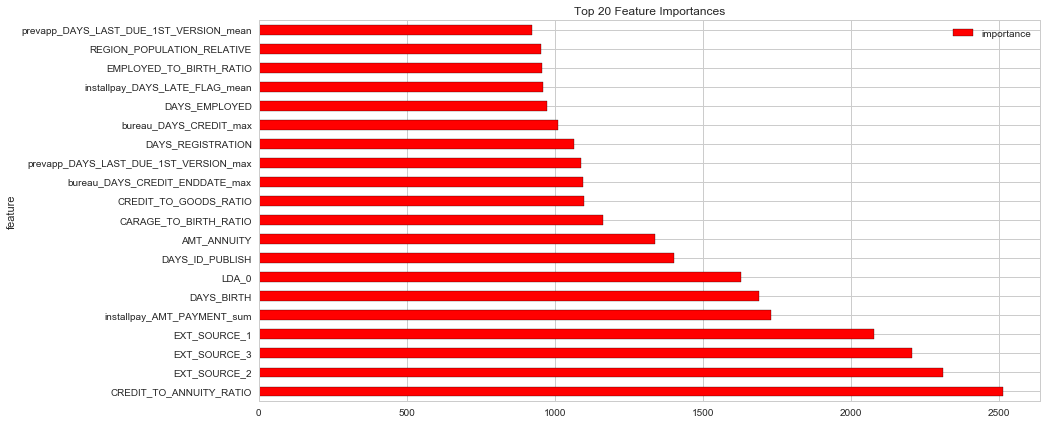

time: 384 ms


In [31]:
pd.options.display.max_rows = 4000
feature_import_df = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

def plot_sorted_feature_importance (df):
    plt.figure(figsize = (12, 8))
    df_sorted = df.sort_values('importance', ascending = False)
    import_threshold = 10
    print('Number of features with importance greater than ', import_threshold, ' = ', np.sum(df_sorted['importance'] > import_threshold))
    df_sorted.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Top 20 Feature Importances',);
    return df_sorted

feature_import_df_sorted = plot_sorted_feature_importance(feature_import_df)
print feature_import_df_sorted

#### Correlation to Target

In [32]:
def find_corr_to_target (df):
    target_corr = df.corr()['TARGET']  #target_corr is correlation of specific variables to target 
    target_corr = target_corr.sort_values()
    return target_corr # Correlation to target variable

pd.options.display.max_rows = 4000
target_corr = find_corr_to_target(train) #can use subset or all
print ('Correlation to Target')
print target_corr

Correlation to Target
EXT_SOURCE_2                                    -0.160295
EXT_SOURCE_3                                    -0.155892
EXT_SOURCE_1                                    -0.098887
EMPLOYED_TO_BIRTH_RATIO                         -0.049603
NAME_INCOME_TYPE_Pensioner                      -0.046209
DAYS_EMPLOYED_ANOM                              -0.045987
ORGANIZATION_TYPE_XNA                           -0.045987
bb_MONTHS_BALANCE_size_mean                     -0.044119
prevapp_RATE_DOWN_PAYMENT_max                   -0.041021
HOUSETYPE_MODE_block of flats                   -0.040594
prevapp_AMT_ANNUITY_mean                        -0.040200
CARAGE_TO_BIRTH_RATIO                           -0.039817
AMT_GOODS_PRICE                                 -0.039623
FLOORSMAX_AVG                                   -0.039385
FLOORSMAX_MEDI                                  -0.039157
OCCUPATION_TYPE_unknown                         -0.038690
FLOORSMAX_MODE                                  -0

#### Correlation between variables (multicollinearity)

In [33]:
def find_multicollinearity (df, threshold = 0.8):
    corrs = df.corr()
    above_threshold_vars = {} # dictionary to hold correlated variables

    # Record variables that are above threshold.
    for col in corrs:  
        above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

    # Track of columns already examined
    drop_these_columns = []
    drop_these_columns_pairs = []
    cols_seen = []
    for key, value in above_threshold_vars.items():
        cols_seen.append(key)
        for x in value:
            if x == key:
                next
            else: # Only want to remove one in a pair
                if x not in cols_seen:
                    drop_these_columns.append(x)
                    drop_these_columns_pairs.append(key)
            
    drop_these_columns = list(set(drop_these_columns))
    return above_threshold_vars, drop_these_columns, threshold

# use correlation between variables to identify columns to delete
data_subset = train[[]]
above_threshold_vars, drop_these_columns, threshold = find_multicollinearity (data_subset, .8)
print 'Suggested number of columns to remove with collinearity above', threshold, ': ', len(drop_these_columns)
drop_these_columns

Suggested number of columns to remove with collinearity above 0.8 :  0


[]

time: 31 ms
